# Examine model
We want to examine how the mikenet model works by checking:
1. Whether Chang's weights produce HS04 fig. 12 result
2. What are the Input **direction** and **magnitude**

In [ ]:
import os
import tensorflow as tf
import numpy as np
import meta, modeling, evaluate
os.chdir(os.environ.get("TF_ROOT"))

## Restore to Chang's weights

In [ ]:
cfg = meta.Config.from_json('models/surgery/model_config.json')
model = modeling.MyModel(cfg)
model.build()
ckpt = tf.train.Checkpoint(model=model)
ckpt.restore(os.path.join(cfg.checkpoint_folder,'epoch-1'))
[print(f'{w.name} mean: {w.numpy().mean()}') for w in model.weights]

## Test with mn_r100 testset

In [38]:
mn_r100 = evaluate.load_testset('mn_r100')
model.set_active_task('triangle')
y_pred = model([mn_r100['ort']] * 12)

![HS04 figure 12](/triangle_model/references/hs04_fig12.png)

## Checking the sparse representation still looks good

In [45]:
def dense_to_sparse(dense: np.array) -> list:
    """Convert dense representation to sparse representation."""
    sparse = []
    for i, unit in enumerate(dense):
        if unit == 1:
            sparse.append(i)
    return sparse

def word_to_sparse(testset: dict, word: str) -> dict:
    """Convert word to sparse representation."""
    word_idx = testset['item'].index(word)
    return {f"{x}: {dense_to_sparse(mn_r100[x][word_idx])}" for x in ['ort', 'pho', 'sem']}


word_to_sparse(mn_r100, 'close')

{'ort: [54, 89, 118, 174, 186]',
 'pho: [29, 31, 52, 60, 62, 87, 90, 92, 94, 96, 102, 107]',
 'sem: [4, 6, 29, 46, 49, 104, 209, 236, 813, 913, 1148]'}

In [79]:
# TF style naming to HS04 naming

name_map = {
    'input_hos_hs': 'OS',
    'input_hop_hp': 'OP',
    'input_hps_hs': 'PS',
    'input_css_cs': 'CS'
}

In [78]:
def expand_over_time(x, n_times):
    """Expand representation to n_times to axis 0"""
    x = tf.Variable(x, dtype=tf.float32)
    x = tf.expand_dims(x, axis=0)
    x = tf.tile(x, [n_times, 1, 1])
    return x

sem = expand_over_time(mn_r100['sem'], 13)
pho = expand_over_time(mn_r100['pho'], 13)

# Checking
[tf.assert_equal(sem[i], tf.cast(mn_r100['sem'], dtype=tf.float32)) for i in range(13)]
[tf.assert_equal(pho[i], tf.cast(mn_r100['pho'], dtype=tf.float32)) for i in range(13)]

[None, None, None, None, None, None, None, None, None, None, None, None, None]

In [75]:
def get_inputs(y: tf.Tensor, mask: tf.Tensor) -> list:
    """Get the input over time tick.
    Assumed dimensions equal between y and mask:
        y: (timetick, word, unit)
    """
    assert y.shape == mask.shape
    masked_y = mask * y
    mean_y = tf.reduce_sum(masked_y, axis=2) / tf.reduce_sum(mask, axis=2)  # Average over unit dimension
    return tf.reduce_mean(mean_y, axis=1).numpy().tolist()

In [89]:
y_pred.keys()

dict_keys(['input_hos', 'input_hop', 'input_hps', 'input_hsp', 'input_css', 'input_cpp', 'input_sem', 'input_pho', 'input_hps_hs', 'input_css_cs', 'input_hos_hs', 'input_hsp_hp', 'input_cpp_cp', 'input_hop_hp', 'hos', 'hop', 'hps', 'hsp', 'css', 'cpp', 'sem', 'pho'])

In [81]:
# Raw input before TAI
op = get_inputs(y_pred['input_hop_hp'], mask=pho)
os = get_inputs(y_pred['input_hos_hs'], mask=sem)
ps = get_inputs(y_pred['input_hps_hs'], mask=sem)
cs = get_inputs(y_pred['input_css_cs'], mask=sem)

In [93]:
y_pred['input_hop_hp'].shape

TensorShape([13, 100, 200])

In [95]:
y_pred['hop'].shape

TensorShape([13, 100, 500])

In [94]:
# TAI
op = get_inputs(y_pred['hop'], mask=pho)
os = get_inputs(y_pred['hos'], mask=sem)
ps = get_inputs(y_pred['hps'], mask=sem)
cs = get_inputs(y_pred['css'], mask=sem)

AssertionError: 

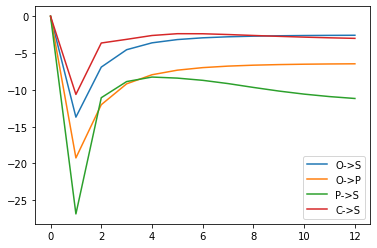

In [88]:
import matplotlib.pyplot as plt
plt.plot(op, label='O->P')
plt.plot(os, label='O->S')
plt.plot(ps, label='P->S')
plt.plot(cs, label='C->S')
plt.legend(loc="lower right")
plt.show()